## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 562.0 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.0
    Uninstalling torchtext-0.17.0:
      Successfully uninstalled torchtext-0.17.0


In [16]:
# import os
# path = './data_OPUS/'
# path_data_src = './data_OPUS/News-Commentary.en-ru.ru'
# path_data_trg = './data_OPUS/News-Commentary.en-ru.en'

# data_src = open(path_data_src, mode='rt')
# data_trg = open(path_data_trg, mode='rt')

# data_src = [line.rstrip() for line in data_src]
# data_trg = [line.rstrip() for line in data_trg]


In [37]:
# import pandas as pd

# df = pd.DataFrame({'src': data_src , 'trg': data_trg})

# path_dataframe = path+ 'dataset.csv'

# df.to_csv(path_dataframe , header=False , index=False)


In [21]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer


In [38]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [41]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_dataframe,
    format='csv',
    fields=[('src', SRC) ,('trg', TRG)]
)

In [43]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [44]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 152083
Number of validation examples: 9505
Number of testing examples: 28516


In [45]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [46]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 58015
Unique tokens in target (en) vocabulary: 27454


Here are tokens from original (RU) corpus:

In [47]:
SRC.vocab.itos[:5]

['<unk>', '<pad>', '<sos>', '<eos>', ',']

In [51]:
SRC.vocab.itos[::10000]

['<unk>', 'беженцами', 'информационного', 'запятнана', 'тайваньских', 'жалобу']

And from target (EN) corpus:

In [53]:
TRG.vocab.itos[::5000]

['<unk>', 'settled', 'fun', 'नष', 'datang', 'fidelio']

And here is example from train dataset:

In [54]:
print(vars(train_data.examples[9]))

{'src': ['более', 'того', ',', 'она', 'дает', 'возможность', 'контроля', 'отдельным', 'потенциальным', 'родителям', '.'], 'trg': ['moreover', ',', 'it', 'gives', 'control', 'to', 'individual', 'prospective', 'parents', '.']}


Let's check the length distributions:

Length distribution in Train data


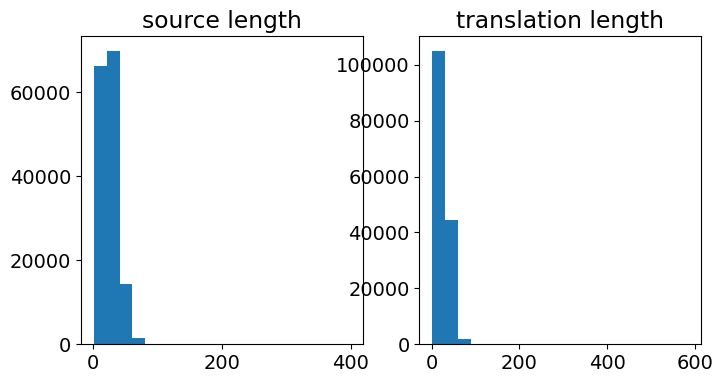

In [55]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


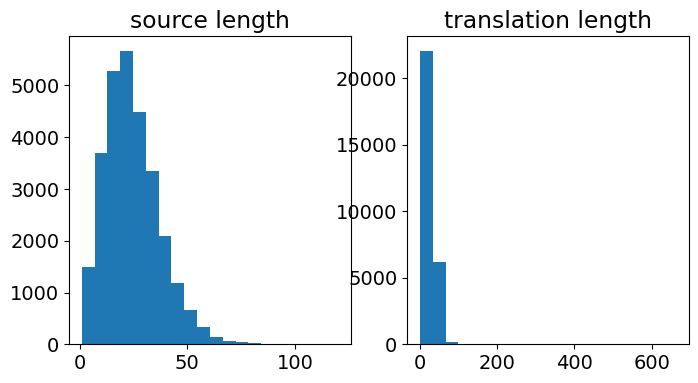

In [56]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 54x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 48x128 (GPU 0)]
torch.Size([48, 128]) torch.Size([54, 128])


In [ ]:
# %rm -rf  ML_advanced_course

In [ ]:
!git clone https://github.com/ThunderstormXX/ML_advanced_course

Cloning into 'ML_advanced_course'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 30 (delta 16), reused 21 (delta 10), pack-reused 0
Receiving objects: 100% (30/30), 96.06 KiB | 24.01 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
%cd ML_advanced_course/

/content/ML_advanced_course


In [ ]:
%ls

lab02_nmt_24s_advanced.ipynb  my_network2.py  my_network.py  __pycache__/  README.md  utils.py


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9221, 512)
    (rnn): LSTM(512, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6663, 512)
    (rnn): LSTM(512, 512, dropout=0.5)
    (out): Linear(in_features=512, out_features=6663, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,753,223 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg
    print(src.shape , trg.shape)
    break

torch.Size([43, 128]) torch.Size([43, 128])


In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

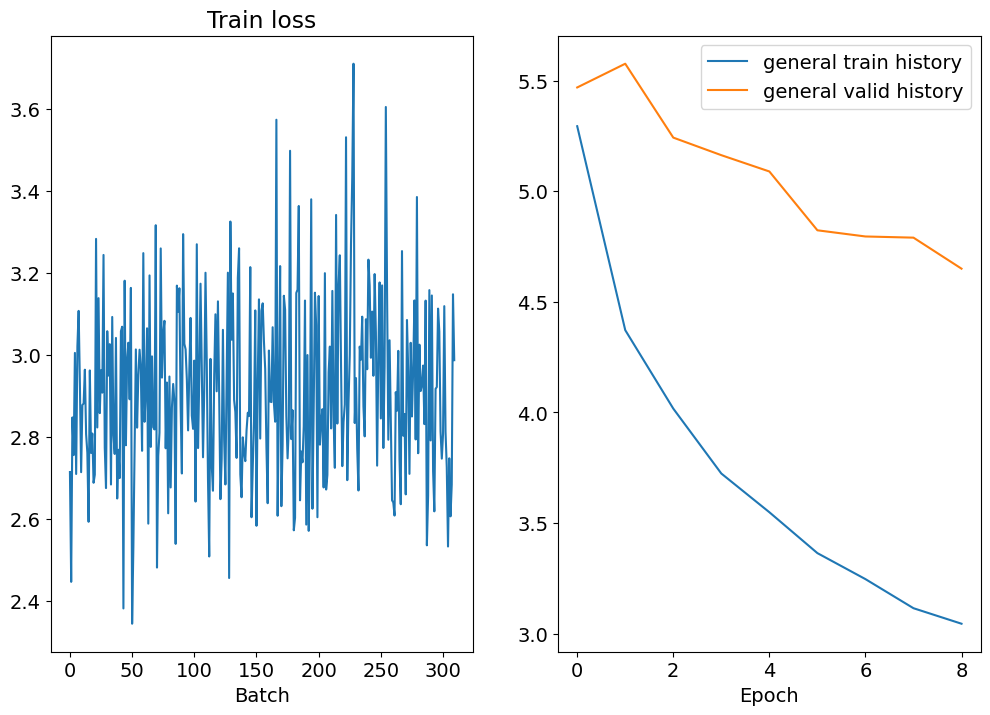

Epoch: 10 | Time: 2m 5s
	Train Loss: 2.914 | Train PPL:  18.421
	 Val. Loss: 4.681 |  Val. PPL: 107.927


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
# del utils

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:07,  7.51it/s]


In [ ]:
len(original_text) , len(original_text[5]) , len(generated_text) , len(generated_text[5])

(7500, 9, 7500, 6)

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.280074156154624

## Модель RNN сразу перееобучается, но дает не плохой результат по метрике BLEU.

# Улучшим RNN : добавим attention (1 implementation over baseline)

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import my_network2
EncoderAtt = my_network2.Encoder
DecoderAtt = my_network2.Decoder
Seq2SeqAtt = my_network2.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM =512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

modelAtt = Seq2SeqAtt(enc, dec, device).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
modelAtt.apply(init_weights)
count_parameters(modelAtt)

17388591

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(modelAtt.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

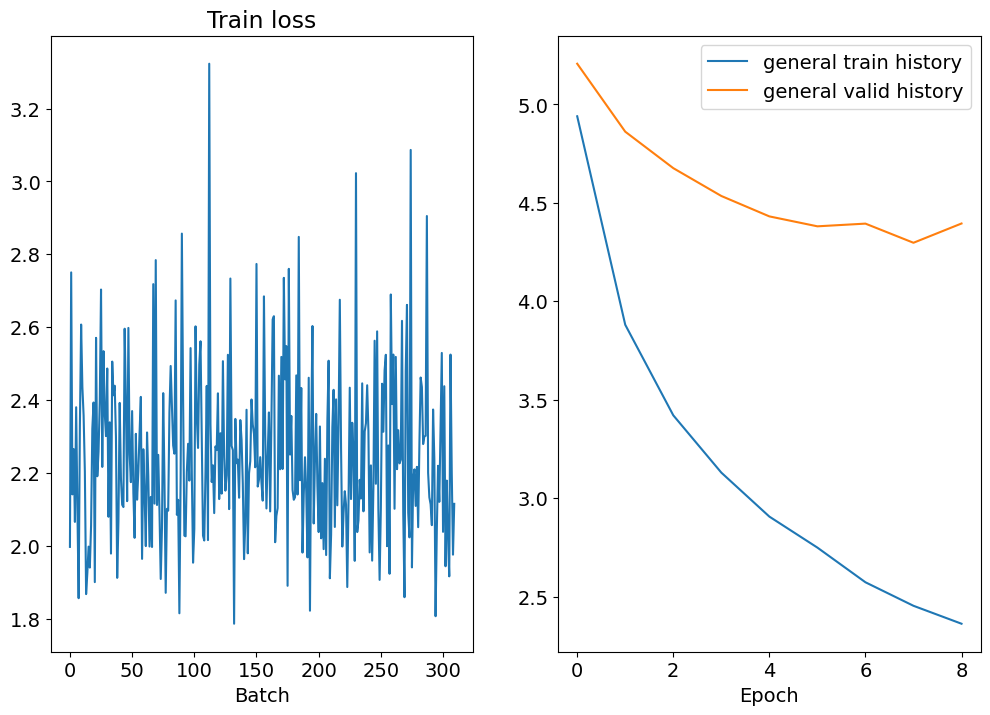

Epoch: 10 | Time: 3m 8s
	Train Loss: 2.250 | Train PPL:   9.488
	 Val. Loss: 4.483 |  Val. PPL:  88.468


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(modelAtt, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(modelAtt, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = modelAtt(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:08,  6.64it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

26.595361211948347

## Модель обучается значительно медленнее из-за attention блока. Так же она медленнее инференсится примерно в 2 раза. Однако немного лучше сходится по train_loss. Имеется такое же переобучение, как и без attention. Сильное преимущество модели с вниманием: дает значительно больший скор BLEU, но число параметров примерно такое же.

# Модель с attention weights == E , то есть сумма скрытых слоев энкодера. С произвольной инициализацией весов

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM =512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, without_attention=True)

modelWithoutAtt = Seq2SeqAtt(enc, dec, device, without_attention=True).to(device)

In [ ]:
modelWithoutAtt.apply(init_weights)
count_parameters(modelWithoutAtt)

16801799

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(modelWithoutAtt.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

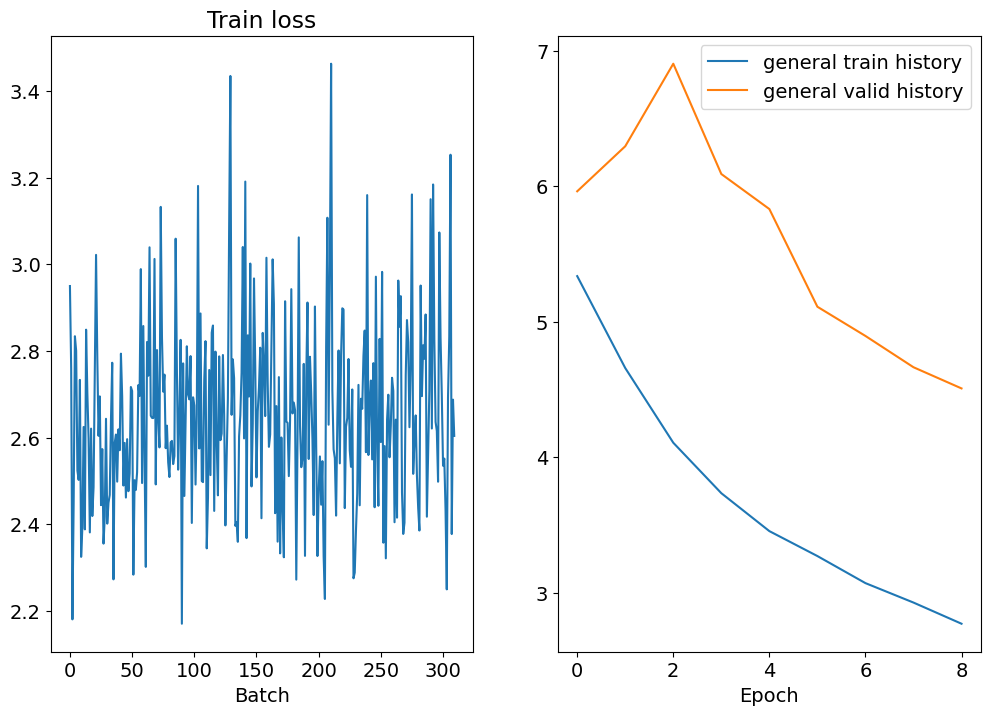

Epoch: 10 | Time: 2m 1s
	Train Loss: 2.652 | Train PPL:  14.182
	 Val. Loss: 4.539 |  Val. PPL:  93.624


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(modelWithoutAtt, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(modelWithoutAtt, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = modelWithoutAtt(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:07,  8.36it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.095775035904035

# Теперь проинициализируем веса модели, с помощью байесовской дистилляции модели с attention

# Улучшим RNN:  попробуем bidirectional rnn с attention (2 implementation over baseline)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM =512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, bidirectional=True)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

modelBiAtt = Seq2SeqAtt(enc, dec, device).to(device)

In [ ]:
modelBiAtt.apply(init_weights)
count_parameters(modelBiAtt)

19430433

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(modelBiAtt.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

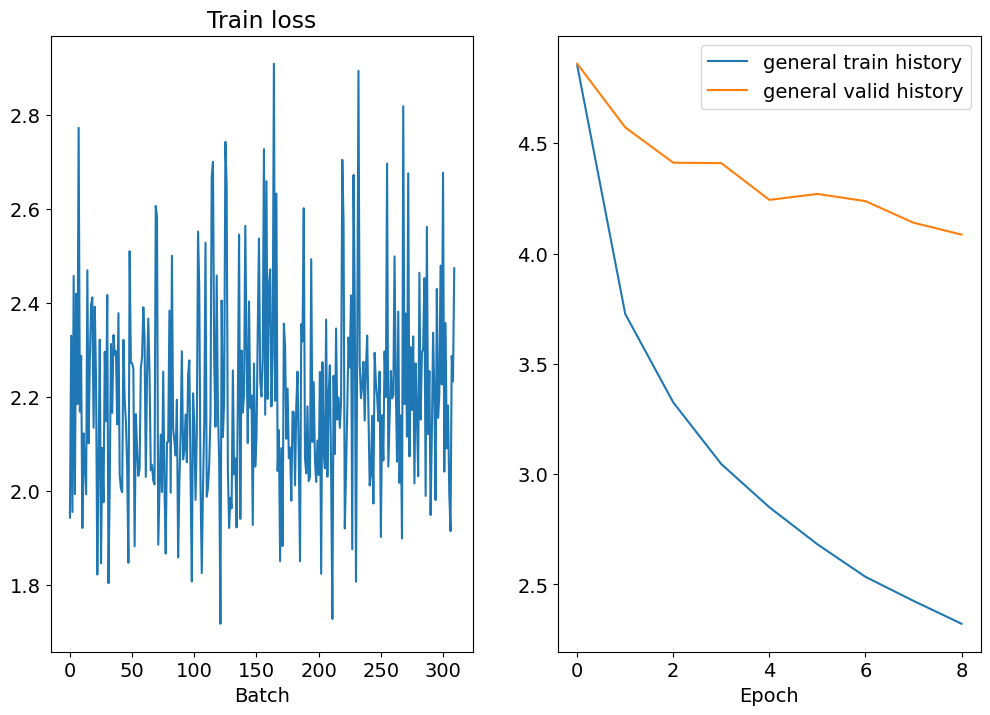

Epoch: 10 | Time: 2m 58s
	Train Loss: 2.197 | Train PPL:   9.002
	 Val. Loss: 4.196 |  Val. PPL:  66.417


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(modelBiAtt, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(modelBiAtt, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = modelBiAtt(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:08,  7.27it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

29.02440161991624

## При тех же гиперпараметрах , что у предыдущей модели, но с дополнительным обратным проходом lstm, модель выдает большее значение метрики bleu на 2 пункта. При этом время работы модели практически такое же , как у предыдущей.

# Обучим трансформер ( 3 implementation over baseline)

In [ ]:
import numpy as np

In [ ]:
import torch.nn as nn
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)
import torch
from torch import Tensor

import math

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int, NHEAD: int  ,
                 dim_feedforward:int = 512, dropout:float = 0.1 ):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        # print('forward encode input shape: (src emb and src mask and src padding mask )' , src_emb.shape, src_mask.shape, src_padding_mask.shape)

        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        # print('forward encode output shape:' , memory.shape )


        # print('forward decode input shape: (tgt emb and tgt mask and tgt padding mask )' , tgt_emb.shape, memory.shape, tgt_mask.shape, None,
                                        # tgt_padding_mask.shape, memory_key_padding_mask.shape)


        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        # print('forward decode output shape:' , outs.shape )


        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        # print('encode input shape: (pos encoded src and src mask)' , self.positional_encoding(
        #                     self.src_tok_emb(src)).shape, src_mask.shape)
        # print('encode output shape:' , self.transformer_encoder(self.positional_encoding(
        #                     self.src_tok_emb(src)), src_mask).shape )

        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        # print('decode input shape: (pos encoded tgt and memory and tgt mask)' , self.positional_encoding(
        #                   self.tgt_tok_emb(tgt)).shape ,memory.shape,
        #                   tgt_mask.shape )
        # print('decode output shape:' , self.transformer_decoder(self.positional_encoding(
        #                   self.tgt_tok_emb(tgt)), memory,
        #                   tgt_mask).shape )
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
SRC_VOCAB_SIZE = len(SRC.vocab)
TGT_VOCAB_SIZE = len(TRG.vocab)
EMB_SIZE = 512
NHEAD = 16
FFN_HID_DIM = 1024
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4


transformer = Seq2SeqTransformer(num_encoder_layers=NUM_ENCODER_LAYERS,
                                num_decoder_layers= NUM_DECODER_LAYERS,
                                emb_size= EMB_SIZE, src_vocab_size= SRC_VOCAB_SIZE,
                                 tgt_vocab_size= TGT_VOCAB_SIZE,
                                 dim_feedforward= FFN_HID_DIM , NHEAD=NHEAD)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

In [ ]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 32,610,833 trainable parameters


In [ ]:
def train_transformer(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src = batch.src
        tgt = batch.trg
        # print(src.shape , tgt.shape)
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]
        # print(tgt_input.shape)
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)
        # print(logits.shape)

        optimizer.zero_grad()

        tgt_out = tgt[1:,:]
        # print(tgt_out.shape)

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)


        optimizer.step()
        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)





    logits = model(src, tgt_input, src_mask, tgt_mask,
                          src_padding_mask, tgt_padding_mask, src_padding_mask)

    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()

def evaluate_transformer(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            tgt = batch.trg
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            logits = model(src, tgt_input, src_mask, tgt_mask,
                          src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:,:]
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

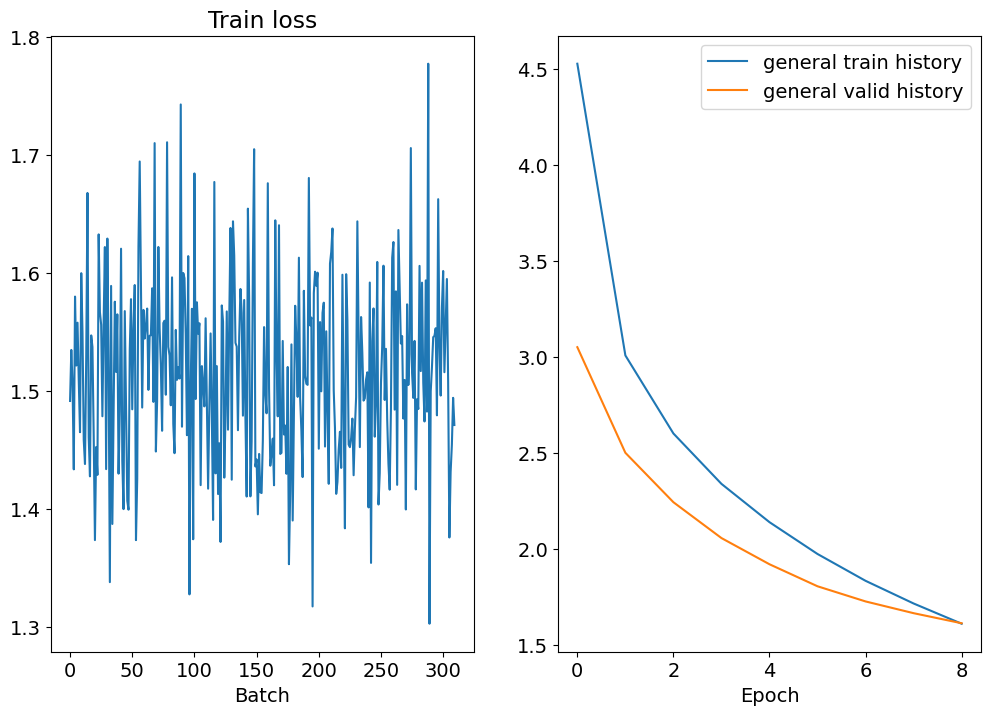

Epoch: 10 | Time: 2m 3s
	Train Loss: 1.516 | Train PPL:   4.553
	 Val. Loss: 1.562 |  Val. PPL:   4.766


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train_transformer(transformer, train_iterator, optimizer, loss_fn, CLIP, train_history, valid_history)
    valid_loss = evaluate_transformer(transformer, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
BOS_IDX = SRC.vocab.stoi['<sos>']

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, num_samples=1):
    src = src.to(device)
    src = torch.cat([src]*num_samples, dim=1)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)

    ys = torch.ones(1, num_samples).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.detach()

        ys = torch.cat([ys,
                        next_word.view(1, -1)], dim=0)
    return ys.transpose(0,1)

In [ ]:

def translate(
    model,
    srcs,
    src_vocab,
    tgt_vocab,
    # src_tokenizer,
    decoder=greedy_decode,
    max_len_add=10,
):
    model.eval()
    # itos = tgt_vocab.get_itos()
    global_answers = []

    for src in srcs:
        num_tokens = len(src)
        src = src.reshape(num_tokens, 1)

        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = decoder(
            model,
            src,
            src_mask,
            max_len=num_tokens + max_len_add,
            start_symbol= BOS_IDX
        )
        # print(tgt_tokens.shape)
        answers = []
        for tgt_token in tgt_tokens:
            reference = []
            for tok in tgt_token:
                tok = int(tok.detach().cpu())
                if tok == TRG.vocab.stoi["<eos>"]:
                    break
                if tok not in {
                    TRG.vocab.stoi["<eos>"],
                    TRG.vocab.stoi["<sos>"],
                    TRG.vocab.stoi["<pad>"],
                }:
                    reference.append(tok)
            global_answers.append(reference)
    return global_answers

In [ ]:
TRG.vocab.stoi["<sos>"]

2

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src.permute(1,0)
        trg = batch.trg
        src = src.to(device)


        tgt_output = translate(
            transformer,
            src,
            SRC.vocab,
            TRG.vocab,
            decoder=greedy_decode
        )
        original_text.append([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.append([get_text(x, TRG.vocab) for x in tgt_output])
        # break
original_text = flatten(original_text)
generated_text = flatten(generated_text)

59it [15:38, 15.91s/it]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.039753031616453

Выбили score > 27

## Выводы: Трансформер
* обучение достаточно быстрое
* переобучение практически не наступает
* Высокие значения BLEU
* Но очень долгий инференс

## Inference (дальше играюсь с переводом с помощью трансформера)

In [ ]:
def inference(idx , batch_idx, iterator) :
  for i,batch in enumerate(iterator) :
      if i == batch_idx :
          # print(batch.src.shape , batch.trg.shape)
          src = batch.src[:,idx:idx+1].permute(1,0)
          trg = batch.trg[:,idx:idx+1].permute(1,0)
          break
  src = src.to(device)
  tgt_output = translate(
      transformer,
      src,
      SRC.vocab,
      TRG.vocab,
      decoder=greedy_decode
  )
  # print(src)
  print('src       : ' , ' '.join([SRC.vocab.itos[token] if int(token) not in {1,2,3} else '' for token in src[0]]).strip())
  print('trg       : ', ' '.join([TRG.vocab.itos[token] if int(token) not in {1,2,3} else '' for token in trg[0]]).strip())
  print('translate : ', ' '.join(get_text(tgt_output[0], TRG.vocab)).strip())


In [ ]:
idx = np.random.randint(low=0,high=127)
batch_idx = np.random.randint(low=0,high=58)
inference(idx,batch_idx,test_iterator)

src       :  гостям предоставляется бесплатный трансфер от / до аэропорта .
trg       :  free transfer to the airport is provided .
translate :  the property offers free airport shuttle service .


In [ ]:
def translator( sentence ):
    src = tokenize(sentence)
    src = [SRC.vocab.stoi['<sos>']] + [SRC.vocab.stoi[word] for word in src ] + [SRC.vocab.stoi['<eos>']]
    src = torch.IntTensor([src])
    # print(src[0])
    src = src.to(device)

    tgt_output = translate(
        transformer,
        src,
        SRC.vocab,
        TRG.vocab,
        decoder=greedy_decode
    )
    # print(tgt_output[0])
    return ' '.join(get_text(tgt_output[0], TRG.vocab)).strip()



In [ ]:
sentence = 'Дом находится у моря'
print(translator(sentence))

the property is located in the sea .


In [ ]:
sentence = 'Столовая находится на пятом этаже'
print(translator(sentence))

the dining room is located on the ground floor .


In [ ]:
import numpy as np

In [ ]:
np.random.choice(np.arange(4,len(SRC.vocab),1),size=5)

array([3671, 6848, 7078, 4541,  132])

In [ ]:
sentence = ''
for j in range(10):
  sentence =' '.join([SRC.vocab.itos[i] for i in np.random.choice(np.arange(4,len(SRC.vocab),1),size = 5 )])

  print(f'{sentence:>80} -----------> {translator(sentence)}\n')

                                       мармариса деревянным пирса челси belhotel -----------> the white pier is blue metres from the property .

                                       hill киева такие destination обставленных -----------> hill bay is located at the distance of the bay .

                                           oceanview соленой изола туры majestic -----------> the white islands of the famous americas islands are offered .

                                   башен стандартным полноценная бульвара балета -----------> the most famous suites have a full full of them .

                          отправляются формате мексиканской сенанг фридрихсхафен -----------> the non - smoking rooms are offered .

                                                 попасть xviii бухты 170 многими -----------> the property offers its own parking .

                       масла коктейлями ассортиментом впечатляющим средневековый -----------> the large children ’ s playground is available f